In [ ]:
#### Install Packages ####
#! pip install git+https://github.com/MCFreddie777/language-check.git # reqired for pycontractions
#! pip install pycontractions
! pip install nltk
! pip install unidecode
! pip install word2number

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5582 sha256=a82e54f970bad0f5b81e64d35991bcae3dfa39290add66981c66518c88363983
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number


In [ ]:
#### Load data from Google Drive ####

from google_drive_downloader import GoogleDriveDownloader as gdd #just to open our file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### Setting Direc
import os
os.chdir("/content/drive/My Drive/LMU-Statistik/SS22/WWC Hackathon for Social Good/wwcode-hackathon-2022/data")

In [ ]:
# Core packages for text processing.

from pathlib import Path
from argparse import Namespace
from collections import Counter
import json
import os
import string
import time
import math
import numpy as np
import pandas as pd
import re
import unidecode

# Libraries for plotting.

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [12, 10]
import seaborn as sns

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

#from matplotlib.ticker import MaxNLocator
#import matplotlib.gridspec as gridspec
#import matplotlib.patches as mpatches

# Loading pytorch packages.

#import torch
#from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
#from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
#torch.manual_seed(seed_val)
#torch.cuda.manual_seed_all(seed_val)
import gensim.downloader as api
#from pycontractions import Contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 4.7 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011737 sha256=a8ae09b5c8cb5c756a56f26943fe82d078e6dd4f7126540ebdf400a2dd36f5f8
  Stored in directory: /root/.cache/pip/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.3.0
    Uninstalling en-core-web-sm-3.3.0:
      Successfully uninstalled en-core-web-sm-3.3.0


/usr/local/lib/python3.7/dist-packages/spacy/util.py:845: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.3.1,<3.4.0
  warnings.warn(warn_msg)


## Fake News Dataset

Use Kaggle Dataset to train a fake news classifier for newspaper coverage.

train.csv: A full training dataset with the following attributes:
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable


### Overview

In [ ]:
fn_train = pd.read_csv("fake-news/train.csv")
fn_test = pd.read_csv("fake-news/test.csv")

In [ ]:
fn_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
print("Shape of train dataset ", fn_train.shape)
print("Columns ", fn_train.columns)
print("Missing values:\n", fn_train.isna().sum())

Shape of train dataset  (20800, 5)
Columns  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
Missing values:
 id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [ ]:
print("Shape of test dataset ", fn_test.shape)
print("Columns ", fn_test.columns)
print("Missing values:\n", fn_test.isna().sum())

Shape of test dataset  (5200, 4)
Columns  Index(['id', 'title', 'author', 'text'], dtype='object')
Missing values:
 id          0
title     122
author    503
text        7
dtype: int64


Continue to work on training data first.

In [ ]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
# Drop rows with missing data in columns title or text
fn_train_no_na = fn_train.dropna(subset=['title', 'text'], axis=0, how="any")
fn_train_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20203 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20203 non-null  int64 
 1   title   20203 non-null  object
 2   author  18285 non-null  object
 3   text    20203 non-null  object
 4   label   20203 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 947.0+ KB


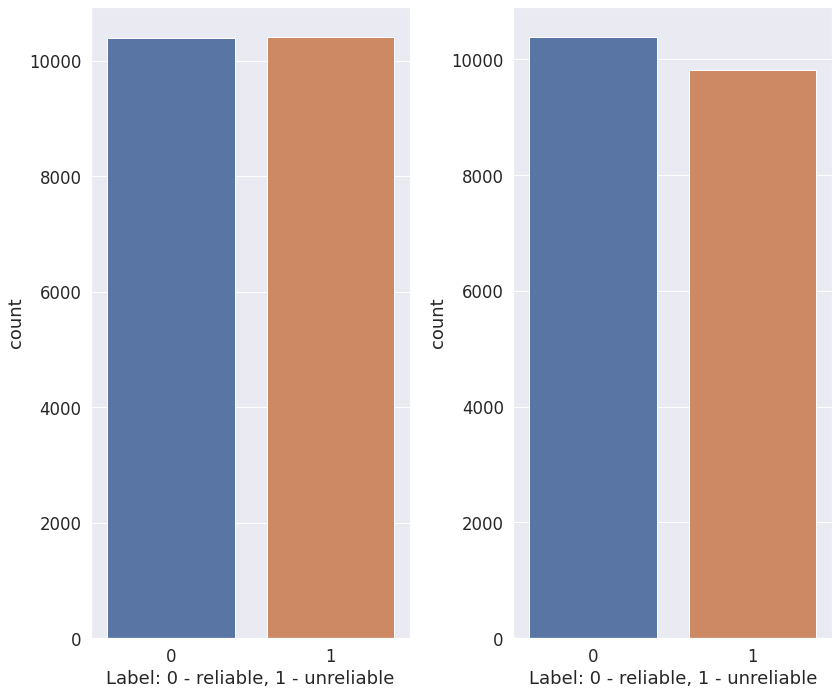

In [ ]:
# Check for class balance
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train, ax=ax1)
sns.countplot(x="label", data=fn_train_no_na, ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

In [ ]:
# Number of articles in each category after removing missing values
fn_train_no_na['label'].value_counts()

0    10387
1     9816
Name: label, dtype: int64

The is slight imbalance after removing the missing values which where mostly present in the 'unreliable' news. 

In [ ]:
# Continue to work without missing data rows
fn_train = fn_train_no_na

In [ ]:
# Check for duplicates
fn_train.drop_duplicates(subset=['title', 'text'], keep='first', inplace=True)

In [ ]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20133 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20133 non-null  int64 
 1   title   20133 non-null  object
 2   author  18240 non-null  object
 3   text    20133 non-null  object
 4   label   20133 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 943.7+ KB


## Understand the structure and properties of articles classified as incredible/fake

First remove HTML-tags which might have been introduced during scaping.

In [ ]:
# remove HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [ ]:
fn_train['text_no_html'] = [remove_html(text) for text in fn_train['text']]
fn_train['title_no_html'] = [remove_html(title) for title in fn_train['title']]

#### Lengths of Titles and Texts

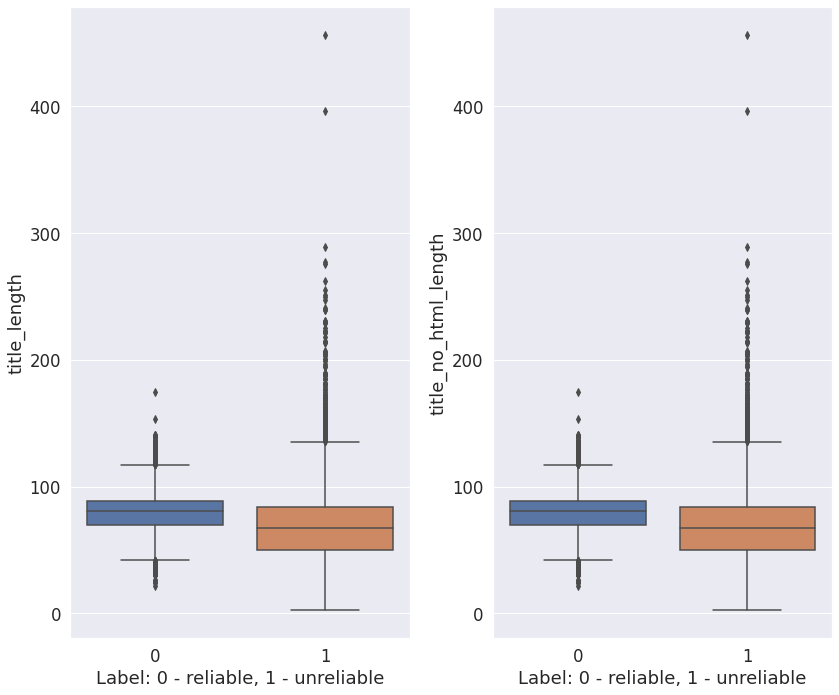

In [ ]:
# Inspecting the titles/headlines of the articles
fn_train['title_length'] = fn_train['title'].apply(lambda x: len(x))
fn_train['title_no_html_length'] = fn_train['title_no_html'].apply(lambda x: len(x))

# Plot title lengths 
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(y='title_length', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='title_no_html_length', x='label', data=fn_train, ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

The titles of credible news are mostly a bit longer than the ones of fake news, but there is an overlap in the IQRs and also the fake news have a lot of outliers upwards, but there are also some articles with really short titles, as the minimum in this category is visibly below the other's minimum. In general, we can say that the title lengths of fake news cover a larger range than the lengths of credible news.

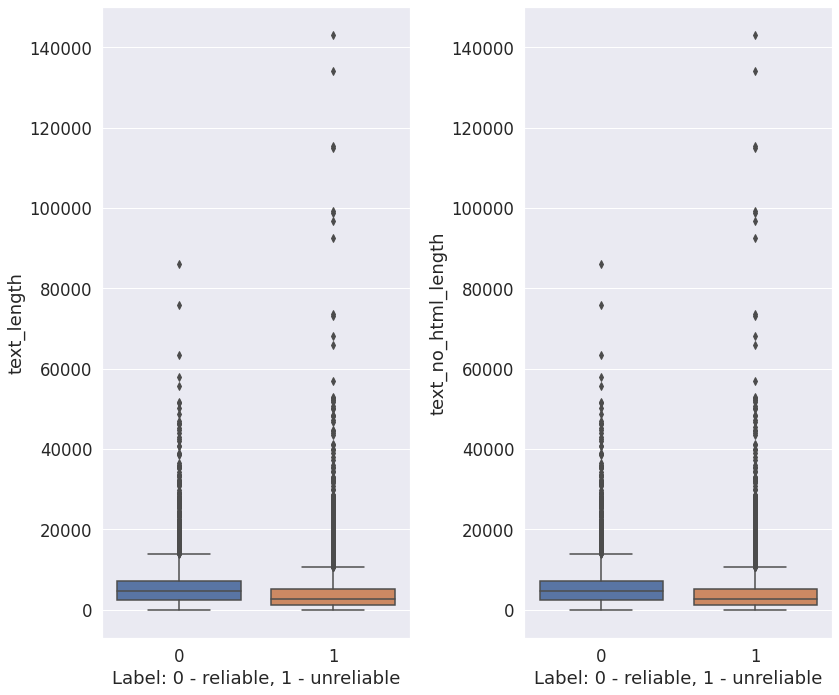

In [ ]:
# Inspecting the article lengths
fn_train['text_length'] = fn_train['text'].apply(lambda x: len(x))
fn_train['text_no_html_length'] = fn_train['text_no_html'].apply(lambda x: len(x))

# Plot title lengths 
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(y='text_length', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='text_no_html_length', x='label', data=fn_train, ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

The credible news seem to be a bit longer in general. The median and IQR lie above those for fake news. Both categories have a lot of outliers, though the outliers in fake news are spread out more towards really long articles with a length nearly twice as much as furthest outlier in the credible category.  
Both catories have a minimum at zero, that needs to be considered in further analysis and might count as missing data.

In [ ]:
fn_train.describe()

,id,label,title_length,text_length,title_no_html_length,text_no_html_length
count,20133.000000,20133.000000,20133.000000,20133.000000,20133.000000,20133.000000
mean,10389.206626,0.484081,74.309740,4663.903293,74.309740,4662.740774
std,6001.327138,0.499759,23.126704,5146.364800,23.126704,5145.550952
min,0.000000,0.000000,3.000000,1.000000,3.000000,1.000000
25%,5197.000000,0.000000,60.000000,1747.000000,60.000000,1744.000000
50%,10393.000000,0.000000,75.000000,3491.000000,75.000000,3491.000000
75%,15576.000000,1.000000,88.000000,6363.000000,88.000000,6363.000000
max,20799.000000,1.000000,456.000000,142961.000000,456.000000,142961.000000


The minimum length of a title is 3 and the minimum length of a text 1 character. That doesn't make much sense.  
The HTML-tag removal only made a slight change in the text length's mean and standard deviation.  
The title lengths are unaffected by it.

In [ ]:
fn_train[fn_train['title_length'] < 5]

,id,title,author,text,label,text_no_html,title_no_html,title_length,text_length,title_no_html_length,text_no_html_length
2561,2561,Wow!,Gillian,http://www.thepoliticalinsider.com/wikileaks-c...,1,http://www.thepoliticalinsider.com/wikileaks-c...,Wow!,4,1214,4,1214
15728,15728,Rum,Kantucky,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,1,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,Rum,3,422,3,422
17081,17081,EPIC,Eric Odom,It didn’t take us long to think of a word to d...,1,It didn’t take us long to think of a word to d...,EPIC,4,2120,4,2120


In [ ]:
fn_train[fn_train['text_no_html_length'] < 5].head()

,id,title,author,text,label,text_no_html,title_no_html,title_length,text_length,title_no_html_length,text_no_html_length
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1,,Huma’s Weiner Dogs Hillary,26,1,26,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,,Mohamad Khweis: Another “Virginia Man” (Palest...,91,1,91,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,,A Connecticut Reader Reports Record Voter Regi...,72,1,72,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,,BULLETIN: There ARE Righteous Jews For Trump!;...,98,1,98,1
592,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,,1,,Is your promising internet career over now Vin...,99,1,99,1


In [ ]:
fn_train[fn_train['text_no_html_length'] < 5].count()

id                      76
title                   76
author                  74
text                    76
label                   76
text_no_html            76
title_no_html           76
title_length            76
text_length             76
title_no_html_length    76
text_no_html_length     76
dtype: int64

The short titles convey a meaning, but the short texts can be counted as missing data.  
There are 76 rows where text is shorter then 5 characters.

In [ ]:
# Remove rows where text is empty
fn_train = fn_train[fn_train['text_no_html_length'] > 5]

In [ ]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20057 entries, 0 to 20799
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    20057 non-null  int64 
 1   title                 20057 non-null  object
 2   author                18166 non-null  object
 3   text                  20057 non-null  object
 4   label                 20057 non-null  int64 
 5   text_no_html          20057 non-null  object
 6   title_no_html         20057 non-null  object
 7   title_length          20057 non-null  int64 
 8   text_length           20057 non-null  int64 
 9   title_no_html_length  20057 non-null  int64 
 10  text_no_html_length   20057 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.8+ MB


In [ ]:
fn_train.describe()

,id,label,title_length,text_length,title_no_html_length,text_no_html_length
count,20057.000000,20057.000000,20057.000000,20057.00000,20057.000000,20057.000000
mean,10390.449220,0.482176,74.323578,4681.57182,74.323578,4680.404896
std,5999.828646,0.499695,23.102631,5148.08029,23.102631,5147.267635
min,0.000000,0.000000,3.000000,9.00000,3.000000,9.000000
25%,5200.000000,0.000000,60.000000,1766.00000,60.000000,1762.000000
50%,10395.000000,0.000000,75.000000,3507.00000,75.000000,3507.000000
75%,15575.000000,1.000000,88.000000,6380.00000,88.000000,6380.000000
max,20799.000000,1.000000,456.000000,142961.00000,456.000000,142961.000000


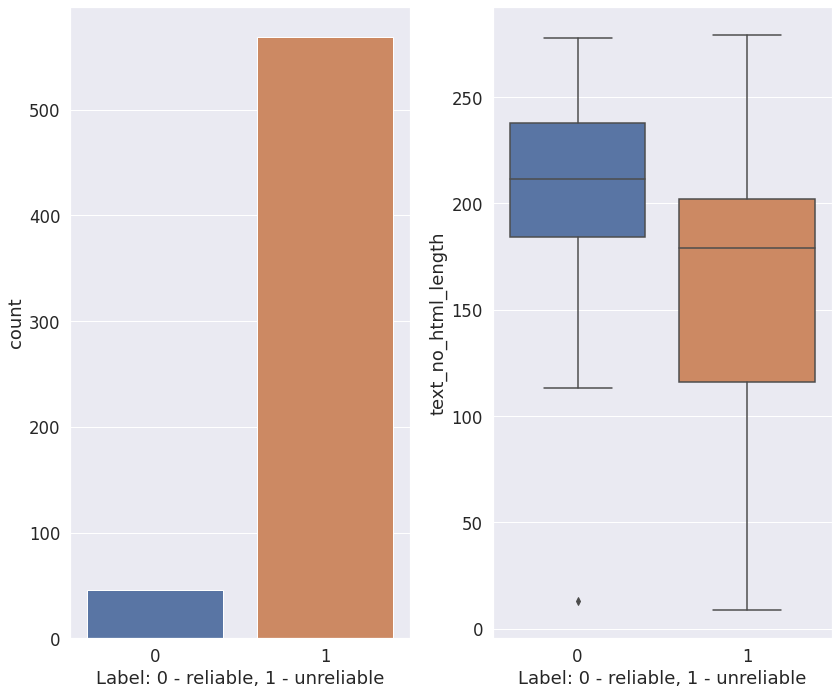

In [ ]:
# Look at short articles and their categories
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train[fn_train['text_no_html_length'] < 280], ax=ax1)
sns.boxplot(y='text_no_html_length', x='label', data=fn_train[fn_train['text_no_html_length'] < 280], ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

Really short articles (same length as a tweet) are mostly found in the fake news category, but there are also some in the reliable news. 

In [ ]:
fn_train[(fn_train['text_no_html_length'] < 280) & (fn_train['label'] == 0)].head()

,id,title,author,text,label,text_no_html,title_no_html,title_length,text_length,title_no_html_length,text_no_html_length
81,81,Turkey Threatens to Open Migrant ’Land Passage...,Breitbart London,(AP) — Turkey’s minister in charge of Europ...,0,(AP) — Turkey’s minister in charge of Europ...,Turkey Threatens to Open Migrant ’Land Passage...,78,208,78,208
2349,2349,Serb Officials Warn Of Another War In The Balkans,Breitbart London,"BELGRADE, Serbia (AP) — Serbian officials w...",0,"BELGRADE, Serbia (AP) — Serbian officials w...",Serb Officials Warn Of Another War In The Balkans,49,212,49,212
3030,3030,Jury Deadlocks in Bill Cosby Trial Mistrial De...,Breitbart News,"NORRISTOWN, Pa. (AP) — Bill Cosby’s trial o...",0,"NORRISTOWN, Pa. (AP) — Bill Cosby’s trial o...",Jury Deadlocks in Bill Cosby Trial Mistrial De...,64,238,64,238
3076,3076,Muslims Protest with Street Prayer in Paris Su...,Breitbart London,PARIS (AP) — Hemmed in and closely watched ...,0,PARIS (AP) — Hemmed in and closely watched ...,Muslims Protest with Street Prayer in Paris Su...,50,222,50,222
3651,3651,Italian Court Convicts Jihadists Plotting Rome...,Breitbart London,MILAN (AP) — An Italian court has convicted...,0,MILAN (AP) — An Italian court has convicted...,Italian Court Convicts Jihadists Plotting Rome...,53,220,53,220


In [ ]:
fn_train[(fn_train['text_length'] < 280) & (fn_train['label'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 81 to 20685
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    46 non-null     int64 
 1   title                 46 non-null     object
 2   author                44 non-null     object
 3   text                  46 non-null     object
 4   label                 46 non-null     int64 
 5   text_no_html          46 non-null     object
 6   title_no_html         46 non-null     object
 7   title_length          46 non-null     int64 
 8   text_length           46 non-null     int64 
 9   title_no_html_length  46 non-null     int64 
 10  text_no_html_length   46 non-null     int64 
dtypes: int64(6), object(5)
memory usage: 4.3+ KB


The short articles in the reliable category seem to be subheadings of the actual articles. There are 46 of these in the training data. 

#### Authors in Each Category

In [ ]:
# Check authors - are there common ones in both categories
gen_news_authors = set(list(fn_train[fn_train['label']==0]['author'].unique()))
fake_news_authors = set(list(fn_train[fn_train['label']==1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: ", len(gen_news_authors))
print("Number of distinct authors with fake articles: ", len(fake_news_authors))
print("Number of distinct authors with both genuine and fake: ", len(overlapped_authors))
print("List of overlapped authors", overlapped_authors)

Number of distinct authors with genuine articles:  2226
Number of distinct authors with fake articles:  1613
Number of distinct authors with both genuine and fake:  6
List of overlapped authors {nan, 'AFP', 'Reuters', 'Ann Coulter', 'Pamela Geller', 'Pam Key'}


### Further Characteristics

In [ ]:
fn_train.head()

,id,title,author,text,label,text_no_html,title_no_html,title_length,text_length,title_no_html_length,text_no_html_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,81,4930,81,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",55,4160,55,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired,33,7692,33,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...,63,3237,63,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...,93,938,93,938


#### Urls and handlers (@ symbols)

In [ ]:
# Count urls/handles in texts
regex_urls = 'r"[A-Za-z0-9]+://[A-Za-z0-9%-_]+(/[A-Za-z0-9%-_])*(#|\\?)[A-Za-z0-9%-_&=]*"'
regex_handles = 'r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)"'

fn_train['num_urls'] = [len(re.findall(regex_urls, text)) for text in fn_train['text_no_html']]
fn_train['num_handles'] = [len(re.findall(regex_handles, text)) for text in fn_train['text_no_html']]

In [ ]:
fn_train[['num_urls', 'num_handles']].describe()

,num_urls,num_handles
count,20057.0,20057.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


There are no urls or Twitter handles present in the texts.

#### Use of Exclamation point and Question Marks

In [ ]:
# Count exclamation points and question marks in text/title

fn_train['num_exclam_title'] = [len(re.findall(r"!", text)) for text in fn_train['title_no_html']]
fn_train['num_exclam_text'] = [len(re.findall(r"!", text)) for text in fn_train['text_no_html']]

fn_train['num_quest_title'] = [len(re.findall(r"\?", text)) for text in fn_train['title_no_html']]
fn_train['num_quest_text'] = [len(re.findall(r"\?", text)) for text in fn_train['text_no_html']]

In [ ]:
fn_train[['num_exclam_title', 'num_exclam_text', 'num_quest_title', 'num_quest_text']].describe()

,num_exclam_title,num_exclam_text,num_quest_title,num_quest_text
count,20057.000000,20057.000000,20057.000000,20057.000000
mean,0.033106,0.599890,0.061475,1.445979
std,0.225076,3.137554,0.248771,4.235523
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,2.000000
max,9.000000,213.000000,5.000000,159.000000


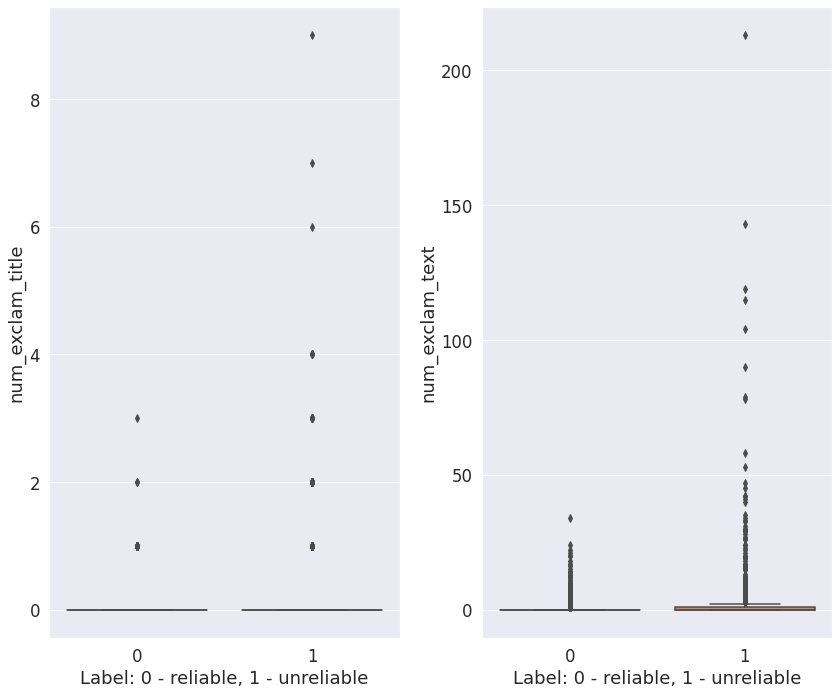

In [ ]:
# Plot exclamation point count in title and text
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(y='num_exclam_title', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='num_exclam_text', x='label', data=fn_train, ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

Fake news uses more exclamation points in title and text.

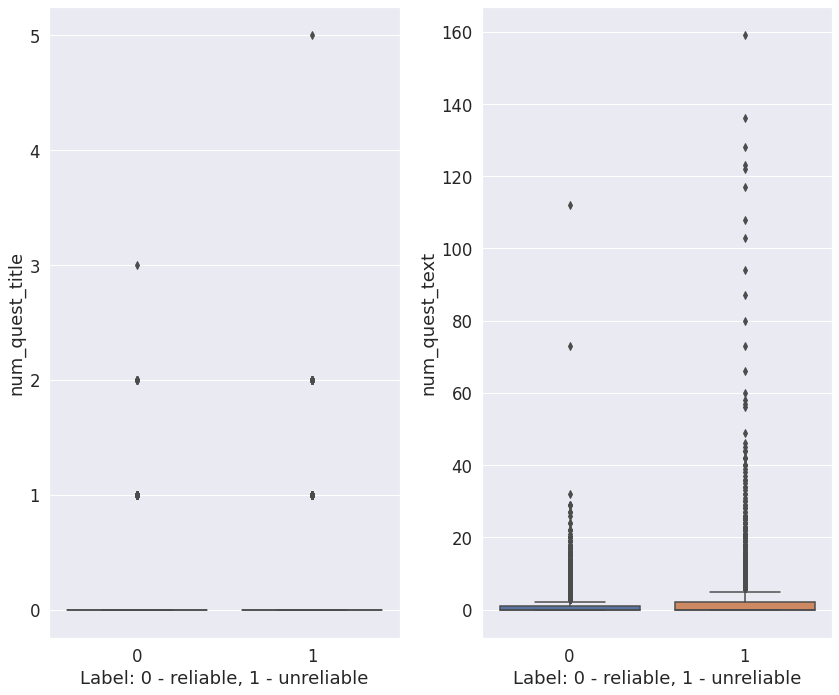

In [ ]:
# Plot exclamation point count in title and text
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(y='num_quest_title', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='num_quest_text', x='label', data=fn_train, ax=ax2)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

Question marks in titles are used by both categories only up to 5 times.  
In the texts both categories use question marks in general relatively few times, but unreliable news has a wider 5-point-statistic and the outliers in this category surpass the the ones in the reliable category.  
To make proper comparisons, we're calculating the density for exclamation point and question mark by dividing the number of the specific character in the text by the text length.

In [ ]:
# Calculate densities for exclamation points and question marks
fn_train['exclam_density_title'] = fn_train['num_exclam_title'] / fn_train['title_no_html_length']
fn_train['exclam_density_text'] = fn_train['num_exclam_text'] / fn_train['text_no_html_length']
fn_train['quest_density_title'] = fn_train['num_quest_title'] / fn_train['title_no_html_length']
fn_train['quest_density_text'] = fn_train['num_exclam_text'] / fn_train['text_no_html_length']

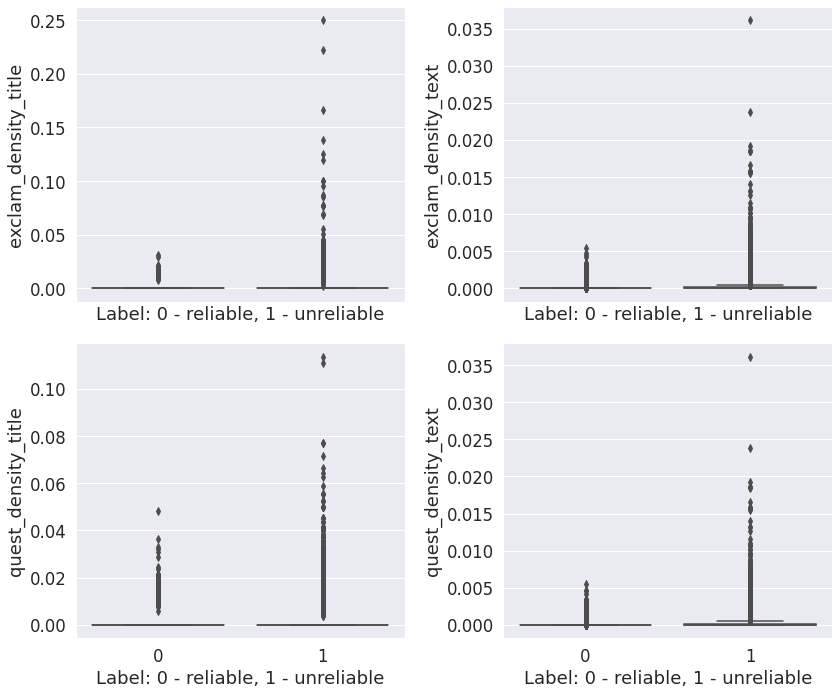

In [ ]:
# Plot exclamation point and question mark densities in title and text
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True)
sns.boxplot(y='exclam_density_title', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='exclam_density_text', x='label', data=fn_train, ax=ax2)
sns.boxplot(y='quest_density_title', x='label', data=fn_train, ax=ax3)
sns.boxplot(y='quest_density_text', x='label', data=fn_train, ax=ax4)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax3.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax4.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

The use of both punctuation variants is even relative to text length more present in unreliable news.

#### Use of Emojies and # Symbols

In [ ]:
# Count emojis
regex_emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)

fn_train['num_emojis_title'] = [len(regex_emojis.findall(text)) for text in fn_train['title_no_html']]
fn_train['num_emojis_text'] = [len(regex_emojis.findall(text)) for text in fn_train['text_no_html']]

# Count Hash symbols
fn_train['num_hash_title'] = [len(re.findall(r"#", text)) for text in fn_train['title_no_html']]
fn_train['num_hash_text'] = [len(re.findall(r"#", text)) for text in fn_train['text_no_html']]

In [ ]:
fn_train[['num_emojis_title', 'num_emojis_text', 'num_hash_title', 'num_hash_text']].describe()

,num_emojis_title,num_emojis_text,num_hash_title,num_hash_text
count,20057.000000,20057.000000,20057.000000,20057.000000
mean,0.000249,0.048262,0.003939,0.155856
std,0.021182,0.681954,0.067244,1.104502
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,2.000000,48.000000,3.000000,43.000000


In [ ]:
# Calculate densities for emojies and hash symbols
fn_train['emoji_density_title'] = fn_train['num_exclam_title'] / fn_train['title_no_html_length']
fn_train['emoji_density_text'] = fn_train['num_exclam_text'] / fn_train['text_no_html_length']
fn_train['hash_density_title'] = fn_train['num_quest_title'] / fn_train['title_no_html_length']
fn_train['hash_density_text'] = fn_train['num_exclam_text'] / fn_train['text_no_html_length']

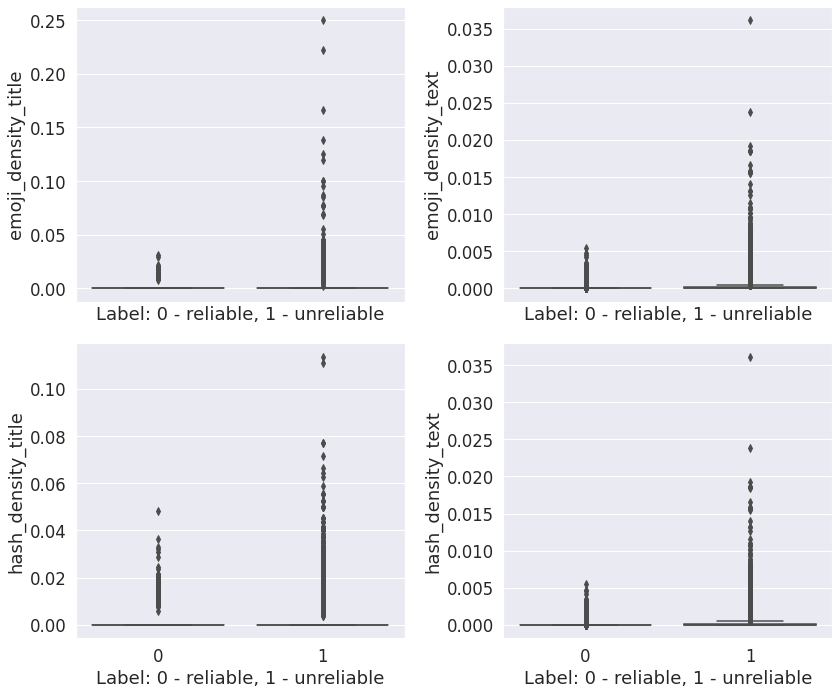

In [ ]:
# Plot emoji and hash symbol densities in title and text
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True)
sns.boxplot(y='emoji_density_title', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='emoji_density_text', x='label', data=fn_train, ax=ax2)
sns.boxplot(y='hash_density_title', x='label', data=fn_train, ax=ax3)
sns.boxplot(y='hash_density_text', x='label', data=fn_train, ax=ax4)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax3.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax4.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

Hash symbols and emojies seem to be more present in category 1, although category 0 also uses them.

#### Hashtags Used - !TODO

#### Use of Numbers

In [ ]:
# Use of numbers in title and text

# Count Numbers 
fn_train['num_nums_title'] = [len(re.findall(r"[0-9]+", text)) for text in fn_train['title_no_html']]
fn_train['num_nums_text'] = [len(re.findall(r"[0-9]+", text)) for text in fn_train['text_no_html']]

# Calculate densities for numbers
fn_train['num_density_title'] = fn_train['num_nums_title'] / fn_train['title_no_html_length']
fn_train['num_density_text'] = fn_train['num_nums_text'] / fn_train['text_no_html_length']

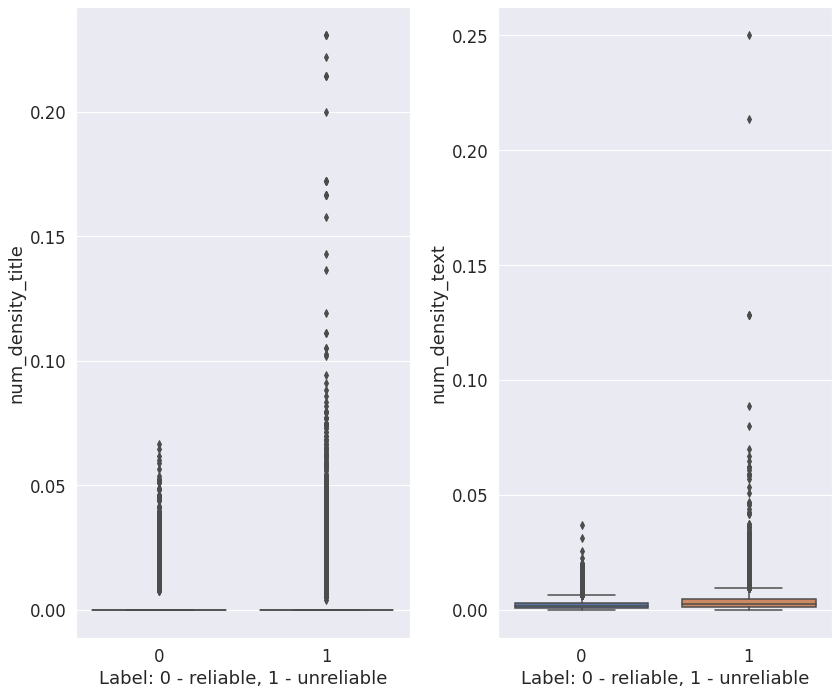

In [ ]:
# Plot number densities in title and text
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
sns.boxplot(y='num_density_title', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='num_density_text', x='label', data=fn_train, ax=ax2)

ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')

fig.tight_layout()
plt.show()

Although both mainly don't use numbers in the title, there are some outliers in both categories and category 1 is more prominent here.  
Both categories use some numbers in the text, but distribution in fake news is wider and has a higher median. The outliers in this category are again more prominent towards higher values compared to category 0.

#### Sentence Lengths

In [ ]:
# Remove emojies
def remove_emojis(text):
  emoji_pattern = re.compile(
      '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [ ]:
# Remove emojies and # symbols from title and text
fn_train['title_no_symbols']  = fn_train['title_no_html'].apply(lambda x: remove_emojis(x))
fn_train['title_no_symbols']  = fn_train['title_no_symbols'].apply(lambda x: re.sub(r"#", '', x))

fn_train['text_no_symbols']  = fn_train['text_no_html'].apply(lambda x: remove_emojis(x))
fn_train['text_no_symbols']  = fn_train['text_no_symbols'].apply(lambda x: re.sub(r"#", '', x))

In [ ]:
# Tokenize into sentences
# Standard tokenizer doesn't consider newlines
# Two-step solution: 1 - split into paragraphs, 2 - tokenize into sentences
def extended_sent_tokenize(text):
  paragraphs = text.split('\n')
  for paragraph in paragraphs:
    return sent_tokenize(paragraph)

In [ ]:
# Tokenize text into sentences
fn_train['sent_tokens'] = [extended_sent_tokenize(text) for text in fn_train['text_no_symbols']]

In [161]:
# Count sentence length (in characters)
fn_train['sent_token_len'] = fn_train['sent_tokens'].apply(lambda x: [len(sentence) for sentence in x])

In [178]:
# Calculate summary statistics and average
fn_train['mean_sent_len'] = fn_train['sent_token_len'].apply(np.array).apply(np.mean)
fn_train['median_sent_len'] = fn_train['sent_token_len'].apply(np.array).apply(np.median)
fn_train['min_sent_len'] = fn_train['sent_token_len'].apply(np.array).apply(lambda x: 0 if x.size == 0 else np.min(x))
fn_train['max_sent_len'] = fn_train['sent_token_len'].apply(np.array).apply(lambda x: 0 if x.size == 0 else np.max(x))

In [179]:
fn_train[['sent_tokens', 'sent_token_len', 'mean_sent_len', 'median_sent_len', 'min_sent_len', 'max_sent_len']].head()

,sent_tokens,sent_token_len,mean_sent_len,median_sent_len,min_sent_len,max_sent_len
0,[House Dem Aide: We Didn’t Even See Comey’s Le...,[259],259.000000,259.0,259,259
1,[Ever get the feeling your life circles the ro...,"[123, 92, 152, 135, 276, 144, 238, 212, 229, 2...",142.448276,135.0,23,277
2,"[Why the Truth Might Get You Fired October 29,...",[50],50.000000,50.0,50,50
3,[Videos 15 Civilians Killed In Single US Airst...,"[240, 100, 19, 10]",92.250000,59.5,10,240
4,[Print],[5],5.000000,5.0,5,5


In [180]:
fn_train[['sent_tokens', 'sent_token_len', 'mean_sent_len', 'median_sent_len', 'min_sent_len', 'max_sent_len']].describe()

,mean_sent_len,median_sent_len,min_sent_len,max_sent_len
count,19664.000000,19664.000000,20057.000000,20057.000000
mean,115.495765,109.569467,41.586479,228.592262
std,61.840672,61.286277,60.302145,152.717809
min,1.000000,1.000000,0.000000,0.000000
25%,82.465672,74.000000,4.000000,107.000000
50%,118.000000,109.500000,19.000000,243.000000
75%,146.500000,141.000000,52.000000,317.000000
max,2072.000000,2072.000000,2072.000000,3053.000000


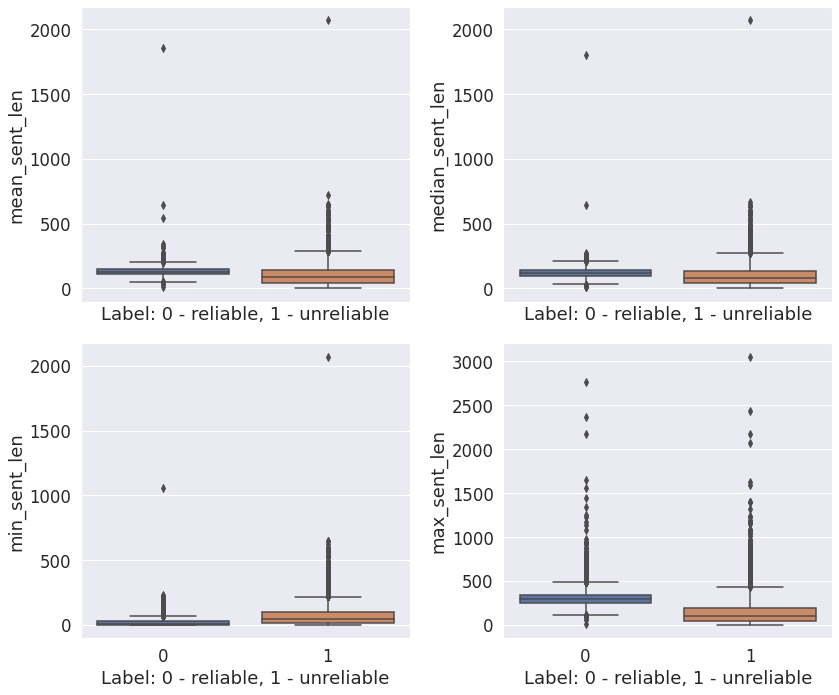

In [181]:
# Plot emoji and hash symbol densities in title and text
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True)
sns.boxplot(y='mean_sent_len', x='label', data=fn_train, ax=ax1)
sns.boxplot(y='median_sent_len', x='label', data=fn_train, ax=ax2)
sns.boxplot(y='min_sent_len', x='label', data=fn_train, ax=ax3)
sns.boxplot(y='max_sent_len', x='label', data=fn_train, ax=ax4)
ax1.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax2.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax3.set(xlabel='Label: 0 - reliable, 1 - unreliable')
ax4.set(xlabel='Label: 0 - reliable, 1 - unreliable')
fig.tight_layout()
plt.show()

In general the reliable category uses longer sentences, although there are some outliers in all four statistics.  
The minimum length seems to be shorte in the reliable category compared to the other one.

#### Word Level Characteristics

In [182]:
fn_train['title_no_html'].iloc[2]

'Why the Truth Might Get You Fired'

In [183]:
fn_train['text_no_html'].iloc[2]

'Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval Off

##### Word-Level Pre-Processing

In [ ]:
### Clean text - helper functins

# Remove HTML tags
# Remove urls, Twitter handles
# Remove special characters, hash symbols, emojies
# Remove newlines
# Convert to lowercase
# Remove puntuation

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_urls_handles(text):
  regex_urls = 'r"[A-Za-z0-9]+://[A-Za-z0-9%-_]+(/[A-Za-z0-9%-_])*(#|\\?)[A-Za-z0-9%-_&=]*"'
  regex_handles = 'r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)"'
  pass

def remove_special_chars(text):
  pass

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

def replace_newlines(text):
  pass

def remove_punctuation(text):
  pass

In [ ]:
### Clean text
def clean_text(text):
  pass

In [ ]:
# Tokenize: words

In [ ]:
# Stemming and/or Lemmatization

In [ ]:
# Count words

In [ ]:
# Removing stopwords

In [ ]:
# Count words and calculate ratio w/o stopword to w stopwords

In [ ]:
# Wordclouds

8


In [ ]:
# Keywords per category

In [ ]:
# Topics in all data
# Check prevalence in each category



---



### Dealing with contractions - maybe later

In [ ]:
# downloads the model for expanding contractions
model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
re.findall(r"[a-zA-z]+\'[a-zA-z]+", test_text)

["Hillary's",
 "Hillary's",
 "Trump's",
 "Trump's",
 "Matthew's",
 "they're",
 "It's",
 "he'd",
 "Obama's",
 "Let's",
 "Kasich's",
 "Guevara's",
 "Cuba's",
 "don't",
 "O'Malley",
 "Russia's",
 "administration's",
 "don't",
 "NASA's",
 "Parenthood's",
 "Iran's",
 "government's",
 "can't",
 "Kerry's",
 "Mayor's",
 "America's",
 "We're",
 "director's",
 "Obama's",
 "won't",
 "Clinton's",
 "we'd",
 "Putin's",
 "Jackson's",
 "Obama's",
 "we've",
 "we're",
 "they're",
 "People's",
 "I'm",
 "he'd",
 "we're",
 "we're",
 "President's",
 "didn't",
 "won't",
 "wasn't",
 "gov't",
 "Biden's",
 "government's",
 "he'd",
 "Gosnell's",
 "media's",
 "lamb's",
 "world's",
 "Bloomberg's",
 "Krugman's",
 "they're",
 "can't",
 "Santa's",
 "religion's",
 "Rauf's",
 "Obama's",
 "gov't",
 "gov't",
 "don't",
 "It's",
 "Obama's",
 "Obama's",
 "Obama's",
 "gov't",
 "Obama's",
 "Earth's",
 "people's",
 "didn't",
 "People's",
 "Obama's"]

In [ ]:
### Text cleaning
### Expand contraction

cont = Contractions(kv_model=model)
text = list(cont.expand_texts([test_text], precise=True))
#print(test_text)
print(text)

#def expand_contraction(text):


['In Hillary\'s America, email server scrubs you \nObama transfers his Nobel Peace Prize to anti-Trump rioters \nDemocrats blame Hillary\'s criminal e-mail server for her loss, demand it face prison \nAfraid of "dangerous" Trump presidency, protesters pre-emptively burn America down to the ground \nClinton Foundation in foreclosure as foreign donors demand refunds \nHillary Clinton blames YouTube video for unexpected and spontaneous voter uprising that prevented her inevitable move into the White House \nSudden rise in sea levels explained by disproportionately large tears she would by climate scientists in the aftermath of Trump\'s electoral victory \nFBI director Comey delighted after receiving Nobel Prize for Speed Reading (650,000 emails in one week) \nU.N. deploys troops to American college campuses in order to combat staggeringly low rape rates \nResponding to Trump\'s surging poll numbers, Obama preemptively pardons himself for treason \nFollowing hurricane Matthew\'s failure to

In [ ]:
re.findall(r"[a-zA-z]+\'[a-zA-z]+", text[0])

["Hillary's",
 "Hillary's",
 "Trump's",
 "Trump's",
 "Matthew's",
 "Obama's",
 "Kasich's",
 "Guevara's",
 "Cuba's",
 "O'Malley",
 "Russia's",
 "administration's",
 "NASA's",
 "Parenthood's",
 "Iran's",
 "government's",
 "Kerry's",
 "Mayor's",
 "America's",
 "director's",
 "Obama's",
 "Clinton's",
 "Putin's",
 "Jackson's",
 "Obama's",
 "People's",
 "President's",
 "gov't",
 "Biden's",
 "government's",
 "Gosnell's",
 "media's",
 "lamb's",
 "world's",
 "Bloomberg's",
 "Krugman's",
 "Santa's",
 "religion's",
 "Rauf's",
 "Obama's",
 "gov't",
 "gov't",
 "Obama's",
 "Obama's",
 "Obama's",
 "gov't",
 "Obama's",
 "Earth's",
 "people's",
 "People's",
 "Obama's"]